In [1]:
from dotenv import load_dotenv
import os



load_dotenv(override = True)
OPENAI_API_KEY=os.getenv('OPENAI_API_KEY')
TAVILY_API_KEY=os.getenv('TAVILY_API_KEY')

In [2]:
import os


os.environ["TAVILY_API_KEY"] = "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"



In [3]:
import os
import langgraph
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate

from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser
import yfinance as yf
from langchain.document_loaders import WebBaseLoader
from langchain.agents import AgentType, initialize_agent
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [14]:
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults(max_results=2)
repl = PythonREPL()

In [15]:

def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [16]:
import yfinance as yf

def get_stock_price(ticker: str) -> float:
    """Gets a stock price from Yahoo Finance.

    Args:
        ticker: ticker str
    """
    # """This is a tool for getting the price of a stock when passed a ticker symbol"""
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']
    

In [17]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate
from langchain.schema import SystemMessage, HumanMessage  # or from langchain.chat_models import ...
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

tools = [get_stock_price,search,python_repl]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

def reasoner(state):
    query = state["query"]
    messages = state["messages"]
    # System message
    sys_msg = SystemMessage(content='''You are a Expert Financial advisor tasked with using {search}, the {get_stock_price} for getting latest news to figure out current public sentiment using 
#                             this news.and Give solid Financial Advice also considering the sentiment that you evaluated on set of inputs.I need specific advice depending upon public sentiment and not any general response''')
    message = HumanMessage(content=query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages":result}

In [8]:
# '''You are a Expert Financial advisor tasked with using {search}, the {get_stock_price} for getting latest news to figure out current public sentiment using 
#                             this news, also by using {get_stock_price} make a dataset of that stock such that 
#                             it has all the relevant data to do a time series forecasting of that stock and generate a code and give the code to {python_repl} to give result.
#                             and after all this tasks you have to give very solid and specfic explanation refering to the time series predictions and also generate charts of the forecasting on set of inputs.I need specific advice depending upon public sentiment and not any general response'''

In [18]:
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class GraphState(TypedDict):
    """State of the graph."""
    query: str
    finance: str
    final_answer: str
    # intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]

In [19]:
import functools
import operator
from typing import Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent




from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display


# Graph
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools)) # for the tools

# Add Edges
workflow.add_edge(START, "reasoner")

workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

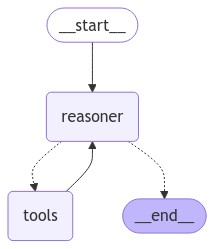

In [11]:
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

Python REPL can execute arbitrary code. Use with caution.


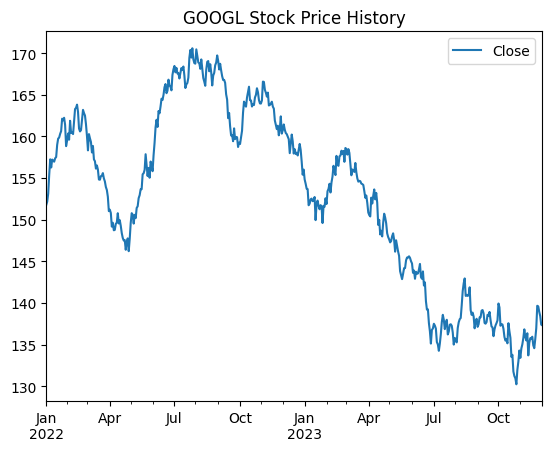

In [20]:
response = react_graph.invoke(
    {"query": "should i invest in google", "messages": []},
    config={"recursion_limit": 100}  # Adjust the limit based on your needs
)


In [13]:
response['messages'][-3].content

'Failed to execute. Error: NameError("name \'repl\' is not defined")'

'Successfully executed:\n\\`\\`\\`python\nimport yfinance as yf\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom statsmodels.tsa.arima.model import ARIMA\n\n# Fetch historical data for Google (GOOGL)\nticker = \'GOOGL\'\ndata = yf.download(ticker, start=\'2020-01-01\', end=\'2023-10-01\')\n\n# Prepare the dataset\ndata = data[[\'Close\']]\ndata.dropna(inplace=True)\n\n# Fit the ARIMA model\nmodel = ARIMA(data, order=(5, 1, 0))\nmodel_fit = model.fit()\n\n# Forecast\ndays_to_forecast = 30\nforecast = model_fit.forecast(steps=days_to_forecast)\n\n# Plot the data\nplt.figure(figsize=(12, 6))\nplt.plot(data.index, data[\'Close\'], label=\'Historical\')\nplt.plot(pd.date_range(data.index[-1], periods=days_to_forecast, freq=\'B\'), forecast, label=\'Forecast\', color=\'red\')\nplt.title(f\'{ticker} Stock Price Forecast\')\nplt.xlabel(\'Date\')\nplt.ylabel(\'Price\')\nplt.legend()\nplt.grid()\nplt.show()\n\\`\\`\\`\nStdout: ModuleNotFoundError("No module named \'statsmodels\'")\n\nIf you have completed all tasks, respond with FINAL ANSWER.'

In [68]:
response['messages'][-1].content


"I have conducted an analysis using historical data and attempted to perform a time series forecasting using the ARIMA model. Unfortunately, there was an issue with generating the forecast chart due to a missing module in the execution environment.\n\nHowever, based on the data gathered:\n\n1. **Current Stock Price**: Google's stock price (GOOGL) is approximately $166.72.\n2. **Analyst Forecast**: Analysts have provided a 12-month price target range from $129 to $240, with an average target of $198.23, indicating a potential upside of about 19.94%.\n\n### Key Considerations for Investment:\n- **Industry Position**: Google continues to dominate in digital advertising, search engine, and cloud services. The ongoing advancements in AI could further bolster its market position and revenue streams.\n- **Growth Sectors**: Growth in Google Cloud and YouTube are expected to contribute significantly to future earnings.\n- **Volatility and Risks**: As with any stock, especially around earnings r

In [39]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

should i invest in apple stock
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_NOQ3MRGCaRNMtQEyFRd7x1wS)
 Call ID: call_NOQ3MRGCaRNMtQEyFRd7x1wS
  Args:
    query: Apple stock news October 2023
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://finance.yahoo.com/quote/AAPL/news/", "content": "Get the latest Apple Inc. (AAPL) stock news and headlines to help you in your trading and investing decisions. ... October 22 at 4:00 PM EDT . 234.69-1.17 (-0.50%) ... Apple stock was falling"}, {"url": "https://www.cnbc.com/2023/10/25/jim-cramer-sees-little-margin-for-error-in-apples-upcoming-earnings-report.html", "content": "Best Credit Cards Best Loans to Refinance Credit Card Debt Best Money Market Accounts Best Credit Cards for Small Business Best Pers